In [4]:
from multiclass_functions1 import *
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets,transforms
import numpy as np
import matplotlib.pyplot as plt
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cpu


In [5]:
# for random seed
import numpy as np
import random
random_seed = 0
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed) # random seed 결정

In [13]:
BATCH_SIZE = 256
LR = 1e-3 # 10^-3
EPOCH = 100
NoB = 2 # layer 개수
NoC = 1 # node 개수
criterion = nn.CrossEntropyLoss() # 분류 문제라서 CE
activation = "Sigmoid"
new_model_train = False
video_save = False
model_type = f"{activation}{NoB}C{NoC}"
# save_model_path = f"/content/drive/MyDrive/Colab Notebooks/results/VG/{model_type}_VG_MNIST.pt"
# save_video_path = f"/content/drive/MyDrive/Colab Notebooks/results/VG/{model_type}.mp4"

In [14]:
transform = transforms.ToTensor()
train_DS = datasets.MNIST(root = '/content/drive/MyDrive/Colab Notebooks/data', train=True, download=True, transform=transform)
test_DS = datasets.MNIST(root = '/content/drive/MyDrive/Colab Notebooks/data', train=False, download=True, transform=transform)
train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=True)

In [15]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        if activation == "Sigmoid":
            self.conv_block = nn.Sequential(
                nn.Conv2d(1,NoC,3, bias=False, padding=1),
                nn.Sigmoid(),
                *[i for j in range(NoB-1) for i in [nn.Conv2d(NoC,NoC,3, bias=False, padding=1), nn.Sigmoid()]]
                )
        elif activation == "BNSigmoid":
            self.conv_block = nn.Sequential(
                nn.Conv2d(1,NoC,3, bias=False, padding=1),
                nn.BatchNorm2d(NoC),
                nn.Sigmoid(),
                *[i for j in range(NoB-1) for i in [nn.Conv2d(NoC,NoC,3, bias=False, padding=1), nn.BatchNorm2d(NoC), nn.Sigmoid()]]
                )
        elif activation == "ReLU":
            self.conv_block = nn.Sequential(
                nn.Conv2d(1,NoC,3, bias=False, padding=1),
                nn.ReLU(),
                *[i for j in range(NoB-1) for i in [nn.Conv2d(NoC,NoC,3, bias=False, padding=1), nn.ReLU()]]
                )
        elif activation == "BNReLU":
            self.conv_block = nn.Sequential(
                nn.Conv2d(1,NoC,3, bias=False, padding=1),
                nn.BatchNorm2d(NoC),
                nn.ReLU(),
                *[i for j in range(NoB-1) for i in [nn.Conv2d(NoC,NoC,3, bias=False, padding=1), nn.BatchNorm2d(NoC), nn.ReLU()]]
                )
        # self.fc = nn.Linear(NoC*(28-2*NoB)*(28-2*NoB),10, bias=False)
        self.maxpool1 = nn.MaxPool2d(2)
        self.maxpool2 = nn.MaxPool2d(2)
        self.fc = nn.Linear(NoC*7*7,10, bias=False)

    def forward(self, x):
        x = self.conv_block(x)
        x = self.maxpool1(x)
        x = self.maxpool2(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

In [16]:
model=CNN().to(DEVICE)
print(model)
x_batch, _ = next(iter(train_DL))
print(model(x_batch.to(DEVICE)).shape)

CNN(
  (conv_block): Sequential(
    (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): Sigmoid()
    (2): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): Sigmoid()
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=49, out_features=10, bias=False)
)
torch.Size([256, 10])


In [17]:
def Train(model, train_DL, criterion):
    optimizer = optim.Adam(model.parameters(), lr=LR)

    loss_history=[]
    acc_history=[]
    mean_grad_history=[]
    mean_weight_history=[]

    NoT=len(train_DL.dataset) # The number of training data

    model.train() # train mode로 전환
    for ep in range(EPOCH):
        rloss = 0 # running loss
        rcorrect = 0 # running correct
        rgrad = torch.zeros(NoB+1) # +1 : 마지막 fc 까지
        rweight = torch.zeros(NoB+1)
        for x_batch, y_batch in train_DL:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            # inference
            y_hat = model(x_batch)
            # loss
            loss = criterion(y_hat, y_batch)
            # update
            optimizer.zero_grad() # gradient 누적을 막기 위한 초기화
            loss.backward() # backpropagation
            optimizer.step() # weight update
            # loss accumulation
            loss_b = loss.item() * x_batch.shape[0] # batch loss # BATCH_SIZE를 곱하면 마지막 18개도 32개를 곱하니까..
            rloss += loss_b
            # accuracy accumulation
            pred = y_hat.argmax(dim=1)
            corrects_b = torch.sum(pred == y_batch).item()
            rcorrect += corrects_b
            # grad and weight (batch)
            with torch.no_grad():
                wlist = [m.weight for m in model.modules() if isinstance(m,nn.Conv2d) or isinstance(m,nn.Linear)]
                rgrad += torch.tensor([w.grad.abs().sum() * x_batch.shape[0] / w.numel() for w in wlist])
                rweight += torch.tensor([w.abs().sum() / w.numel() for w in wlist])
                # print(rweight)
        #         break
        # break
        # grad and weight (epoch)
        mean_grad_history += [rgrad/NoT]
        mean_weight_history += [rweight/len(train_DL)] # len(train_DL) = Batch 가 몇개인지로 나눠
        # print loss
        loss_e = rloss/NoT # epoch loss
        accuracy_e = rcorrect/NoT * 100
        loss_history += [loss_e]
        acc_history += [accuracy_e]
        print(f"Epoch: {ep+1}, train loss: {round(loss_e,3)}, train accuracy: {round(accuracy_e,1)} %")
        print("-"*20)

    return loss_history, acc_history, mean_grad_history, mean_weight_history

In [18]:
if new_model_train:
    loss_history, acc_history, mean_grad_history, mean_weight_history  = Train(model, train_DL, criterion)

    torch.save({"model":model,
                "BATCH_SIZE":BATCH_SIZE,
                "LR":LR,
                "EPOCH":EPOCH,
                "NoB":NoB,
                "NoC":NoC,
                "loss_history":loss_history,
                "acc_history":acc_history,
                "activation":activation,
                "mean_grad_history":mean_grad_history,
                "mean_weight_history":mean_weight_history}, save_model_path)

Test accuracy: 8840/10000 (88.4 %)
508


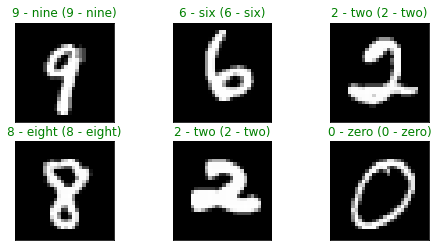

In [19]:
loaded = torch.load(save_model_path, map_location=DEVICE)
load_model = loaded["model"]
loss_history = loaded["loss_history"]
acc_history = loaded["acc_history"]
mean_grad_history = loaded["mean_grad_history"]
mean_weight_history = loaded["mean_weight_history"]
BATCH_SIZE = loaded["BATCH_SIZE"]
LR = loaded["LR"]
EPOCH = loaded["EPOCH"]
NoB = loaded["NoB"]
NoC = loaded["NoC"]
activation = loaded["activation"]

test_acc = Test(load_model, test_DL)
print(count_params(load_model))
Test_plot(load_model, test_DL)

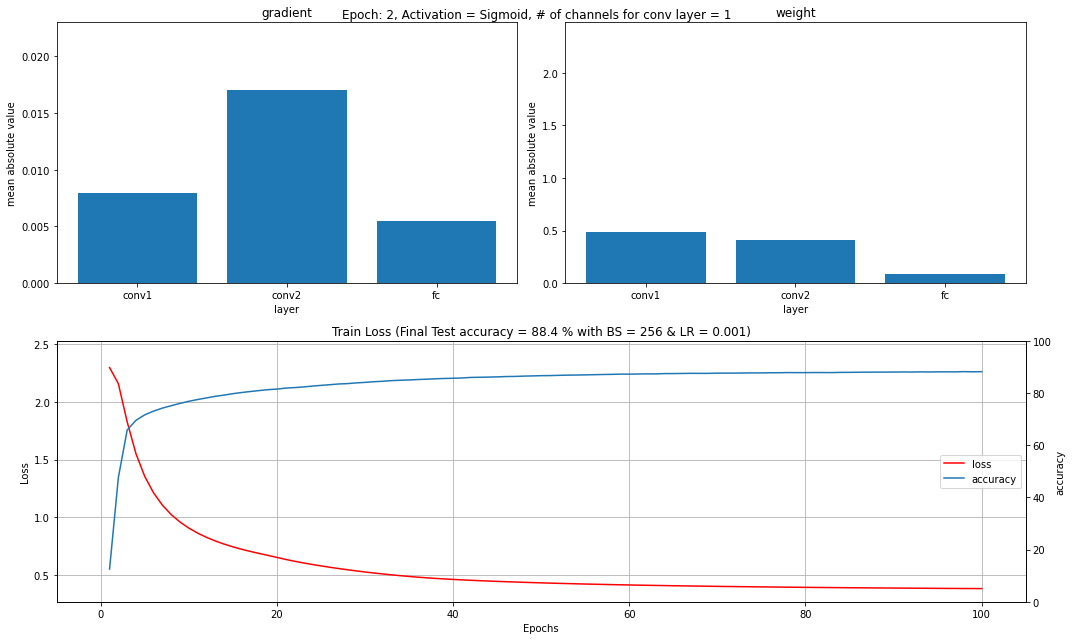

In [20]:
fig = plt.figure(figsize=[15, 9])
ymax_grad = max([i.max().item() for i in mean_grad_history])*1.1
ymax_weight = max([i.max().item() for i in mean_weight_history])*1.1
i = 1

plt.suptitle(f"Epoch: {range(1,EPOCH+1)[i]}, Activation = {activation}, # of channels for conv layer = {NoC}")

plt.subplot(2,2,1)
x_axis = [f"conv{i}" for i in range(1,NoB+1)]+["fc"]
plt.bar(x_axis,mean_grad_history[i].cpu(), width=0.8)
plt.ylim([0,ymax_grad])
plt.xlabel("layer")
plt.ylabel("mean absolute value")
plt.title("gradient")

plt.subplot(2,2,2)
x_axis = [f"conv{i}" for i in range(1,NoB+1)]+["fc"]
plt.bar(x_axis,mean_weight_history[i].cpu(), width=0.8)
plt.ylim([0,ymax_weight])
plt.xlabel("layer")
plt.ylabel("mean absolute value")
plt.title("weight")

ax1 = plt.subplot(2,1,2)
ax2 = ax1.twinx()
p1=ax1.plot(range(1,EPOCH+1),loss_history,'r')
p2=ax2.plot(range(1,EPOCH+1),acc_history)
ax1.set_xlim([-5,EPOCH+5])
ax1.set_ylim([min(loss_history)*0.7, max(loss_history)*1.1])
ax2.set_ylim([0, 100])
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax2.set_ylabel("accuracy")
ax1.set_title(f"Train Loss (Final Test accuracy = {test_acc} % with BS = {BATCH_SIZE} & LR = {LR})")
ax1.grid()
plt.legend(p1+p2,["loss", "accuracy"], loc="right")

plt.tight_layout()

In [21]:
# if video_save:
#     from matplotlib.animation import FuncAnimation
#     fig = plt.figure(figsize=[15, 9])
#     ymax_grad = max([i.max().item() for i in mean_grad_history])*1.1
#     ymax_weight = max([i.max().item() for i in mean_weight_history])*1.1
#     def animate(i): # for 문의 i 라고 생각하면 됨
#         plt.clf()

#         plt.suptitle(f"Epoch: {range(1,EPOCH+1)[i]}, Activation = {activation}, # of channels for a conv layer = {NoC}")

#         plt.subplot(2,2,1)
#         x_axis = [f"conv{i}" for i in range(1,NoB+1)]+["fc"]
#         plt.bar(x_axis, mean_grad_history[i].cpu(), width=0.8)
#         plt.ylim([0,ymax_grad])
#         plt.xlabel("layer")
#         plt.ylabel("mean absolute value")
#         plt.title("gradient")

#         plt.subplot(2,2,2)
#         x_axis = [f"conv{i}" for i in range(1,NoB+1)]+["fc"]
#         plt.bar(x_axis, mean_weight_history[i].cpu(), width=0.8)
#         plt.ylim([0,ymax_weight])
#         plt.xlabel("layer")
#         plt.ylabel("mean absolute value")
#         plt.title("weight")

#         ax1 = plt.subplot(2,1,2)
#         ax2 = ax1.twinx()
#         p1=ax1.plot(range(1,EPOCH+1)[:i+1],loss_history[:i+1],'r')
#         p2=ax2.plot(range(1,EPOCH+1)[:i+1],acc_history[:i+1])
#         ax1.set_xlim([-5,EPOCH+5])
#         ax1.set_ylim([min(loss_history)*0.7, max(loss_history)*1.1])
#         ax2.set_ylim([0, 100])
#         ax1.set_xlabel("Epochs")
#         ax1.set_ylabel("Loss")
#         ax2.set_ylabel("accuracy")
#         ax1.set_title(f"Train Loss (Final Test accuracy = {test_acc} % with BS = {BATCH_SIZE} & LR = {LR})")
#         ax1.grid()
#         plt.legend(p1+p2,["loss","accuracy"], loc="right")

#         plt.tight_layout()

#     ani = FuncAnimation(fig, animate, frames=EPOCH, interval=50)
#     # frames 에 10 넣으면 for i in range(10) 이라고 보면 됨. 혹은 list 넣어주면 in list
#     ani.save(save_video_path, writer='imagemagick')